## Loading Dataset

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

df = pd.read_csv('Project1-ClassificationDataset.csv')
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


### QUESTION 1

- **How many rows (samples) and columns (features) are present in the dataset?**

### QUESTION 1 (answer) -->

In [2]:
print('Number of rows (samples):', df.shape[0])
print('Number of columns (features):', df.shape[1])

Number of rows (samples): 3476
Number of columns (features): 8


- **Histograms: Plot 3 histograms on : (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; (b) The column leaf label – class on the x-axis; (c) The column root label – class on the x-axis.**

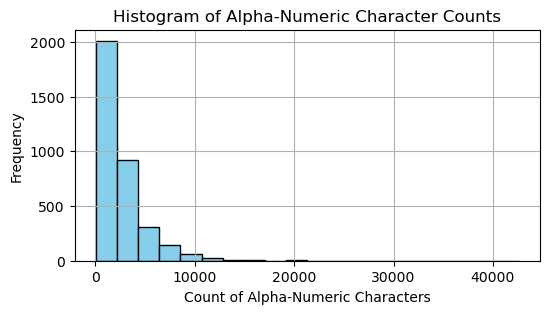

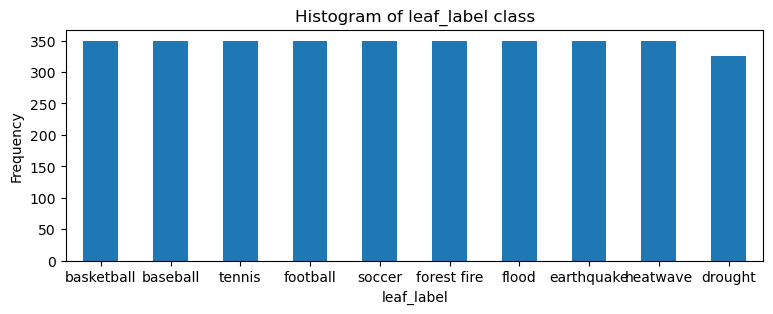

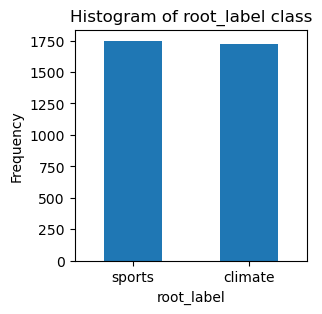

In [3]:
def count_alphanumeric(text):
    return sum(c.isalnum() for c in text)

df['alphanumeric_count'] = df['full_text'].apply(count_alphanumeric)

# Plot histogram
# ---a---
plt.figure(figsize=(6, 3))  

plt.hist(df['alphanumeric_count'], bins=20, color='skyblue', edgecolor='black')  

plt.xlabel('Count of Alpha-Numeric Characters')
plt.ylabel('Frequency')
plt.title('Histogram of Alpha-Numeric Character Counts')

plt.grid(True)  


# ---b---
plt.figure(figsize=(9, 3))  
df['leaf_label'].value_counts().plot(kind='bar', xlabel='leaf_label', ylabel='Frequency', rot=0)
# plt.hist(df['leaf_label'], color='skyblue', edgecolor='black')  

plt.title('Histogram of leaf_label class')


# ---c---
plt.figure(figsize=(3, 3))  

df['root_label'].value_counts().plot(kind='bar', xlabel='root_label', ylabel='Frequency', rot=0)

plt.title('Histogram of root_label class')

plt.show()


In [4]:
df['alphanumeric_count'].describe()

count     3476.000000
mean      2520.624568
std       2454.377145
min         42.000000
25%        960.750000
50%       1807.000000
75%       3231.000000
max      42592.000000
Name: alphanumeric_count, dtype: float64

In [5]:
df['root_label'].value_counts()

root_label
sports     1750
climate    1726
Name: count, dtype: int64

In [6]:
outlier = df[df['alphanumeric_count']>10000]
print(outlier.shape)
print(outlier['root_label'].value_counts())

(47, 9)
root_label
sports     24
climate    23
Name: count, dtype: int64


-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
- **Interpret plots:**

Most of the examples are consisted of less than 10000 characters. 75 percentile of the alpha_numeric count is 3231. There are 47 examples with more than 10000 characters which are outlier and better to be removed. The distribution of the outliers is also balanced among the two classes, sport and climate.

The classes at leaf level are balanced for all the classes (with 350 examples) except 'drought' subclass which less number of examples (326), which is less than (14/13 = 1.076) imbalance ratio.

The classes at root levels are balanced with 1750 and 1726 examples for sports and climate respectively. In this case the imbalance ratio is even less (1.013) 

In [7]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

## Splitting the enitre dataset into training and testing data

### QUESTION 2
**Report the number of training and testing samples.**


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text", "keywords","leaf_label","root_label"]], test_size=0.2)

In [9]:
print ('Answer to Q2:')
print('number of training examples', train.shape[0])
print('number of testing examples', test.shape[0])

Answer to Q2:
number of training examples 2780
number of testing examples 696


## Feature extraction (representation of text data in numbers)
### Question 3: 


In [10]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [11]:
train = train.map(clean)
test = test.map(clean)

In [12]:
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags (Penn TreeBank)
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
wnl = nltk.wordnet.WordNetLemmatizer()
walking_tagged = pos_tag(nltk.word_tokenize('He is walking to school'))
print(walking_tagged)


[('He', 'PRP'), ('is', 'VBZ'), ('walking', 'VBG'), ('to', 'TO'), ('school', 'NN')]


In [13]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent_demo(text):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(nltk.word_tokenize(text))]
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

lemmatize_sent_demo('He is walking to school')

['he', 'be', 'walk', 'to', 'school']

In [14]:
from string import punctuation
analyzer = CountVectorizer().build_analyzer()

stemmer = nltk.stem.SnowballStemmer('english')
def stemmed_words(doc):
    return (stemmer.stem(word) for word in analyzer(doc)if word not in 
            set(punctuation) and \
            not word.isdigit())


def lemmatize_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in
            set(punctuation) and \
             not word.isdigit())

min_df = 3
# stemming
count_vect1 = CountVectorizer(min_df=min_df, analyzer=stemmed_words, stop_words='english')
# lemmatization
count_vect2 = CountVectorizer(min_df=min_df, analyzer=lemmatize_rmv_punc, stop_words='english')

# stemming
X_train_counts1 = count_vect1.fit_transform(train['full_text'])
# lemmatization
X_train_counts2 = count_vect2.fit_transform(train['full_text'])
X_test_counts2 = count_vect2.transform(test['full_text'])


In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts2)
X_test_tfidf = tfidf_transformer.transform(X_test_counts2)


### Q3-a

Please answer the following questions:

- **What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?**


In [16]:
# stemmers
ps = nltk.stem.PorterStemmer()
test_list = ['grows','does','leaves','fairly','article']
for item in test_list:
    print(ps.stem(item))

print("-"*20 + " SnowballStemmer " + "-"*20)
sno = nltk.stem.SnowballStemmer('english')
for item in test_list:
    print(sno.stem(item))

grow
doe
leav
fairli
articl
-------------------- SnowballStemmer --------------------
grow
doe
leav
fair
articl


In [17]:
# lemmetizer
lemmatize_sent(['He', 'is', 'walking', 'to', 'school'])

['he', 'be', 'walk', 'to', 'school']

In [18]:
# comparison of the size of the dictionary for lemmatization and stemming
print('stemming', X_train_counts1.shape)
print('lemmetization',X_train_counts2.shape)


stemming (2780, 11651)
lemmetization (2780, 13593)



### Q3-a (answer)

- Pros of using lemmatization over stemming:

Produces Valid Words: Lemmatization maps words to their canonical forms (lemmas), which are valid words in the language. To do so, lemmatization often involves POS tagging to ensure accurate word transformations based on the word's grammatical role in the sentence. This results in interpretable and meaningful representations of words. For example, stemming results in words like doe, leav, articl which are not valid words.

Contextual Analysis: Lemmatization considers the context of the word in the sentence and uses detailed morphological analysis to map words to their base forms. This results in higher accuracy compared to stemming. Therefore, it is better for Information Retrieval.

- Cons of lemmatization over stemming:

Complexity: Lemmatization is computationally more expensive and complex compared to stemming because it requires access to a dictionary or lexicon and involves more linguistic knowledge.

Noisy Output: Lemmatization may not always produce the desired base form, especially for irregular words or words with ambiguous meanings.

- dictionary size:

As shown in the above cell, Stemming typically reduces the dictionary size more aggresively than lemmatization because it maps different inflected forms of words to the same root. This is because lemmatization maps words to their base forms, which are generally valid words and may have different lemmas for different parts of speech. 


### Q3-b

- **How does varying min_df change the TF-IDF matrix?**

In [19]:

# Sample corpus
corpus = [
    'this is a sample document',
    'another example document',
    'yet another document',
    'this document is different'
]

# Varying min_df values
for min_df in [1, 2, 3]:
    vectorizer = CountVectorizer(min_df=min_df)
    X_counts = vectorizer.fit_transform(corpus)

    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_counts)

    print(f"min_df={min_df}: Number of features (terms) in vocabulary:", \
          len(vectorizer.get_feature_names_out()))
    print(X_tfidf.toarray())
    print("\n average value of the TF_IDF for each document")
    print(X_tfidf.toarray().mean(axis=1))
    print()


min_df=1: Number of features (terms) in vocabulary: 8
[[0.         0.         0.32902288 0.         0.4970962  0.6305035
  0.4970962  0.        ]
 [0.5728925  0.         0.37919167 0.72664149 0.         0.
  0.         0.        ]
 [0.5728925  0.         0.37919167 0.         0.         0.
  0.         0.72664149]
 [0.         0.6305035  0.32902288 0.         0.4970962  0.
  0.4970962  0.        ]]

 average value of the TF_IDF for each document
[0.24421485 0.20984071 0.20984071 0.24421485]

min_df=2: Number of features (terms) in vocabulary: 4
[[0.         0.42389674 0.64043405 0.64043405]
 [0.83388421 0.55193942 0.         0.        ]
 [0.83388421 0.55193942 0.         0.        ]
 [0.         0.42389674 0.64043405 0.64043405]]

 average value of the TF_IDF for each document
[0.42619121 0.34645591 0.34645591 0.42619121]

min_df=3: Number of features (terms) in vocabulary: 1
[[1.]
 [1.]
 [1.]
 [1.]]

 average value of the TF_IDF for each document
[1. 1. 1. 1.]




### Q3-b (answer)

Setting a higher min_df value means that terms must appear in more documents to be included in the vocabulary.
Accordingly, the resulting TF-IDF matrix will likely have fewer columns (features) because only more common terms are retained.

Since the tfdif matrix is normalization of the token counts, as there are less number of tokens for higher min-df, the average values of the TF_IDF matrix goes higher.

### Q3-c

**Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.**

### Q3-c (answer)

Stopwords, punctuations and numbers are better to be removed after lemmatizing to not interfere with the lemmatization process. Also it is worth mentioning that when using tf-idf, the weighting scheme assign a very low idf score for stopwords, and thus removing stopwords is less importance.


### Q3-d

**Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×10^3. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay**


In [20]:
print ('shape of the TF_IDF processed train',X_train_tfidf.shape)
print ('shape of the TF_IDF processed test',X_test_tfidf.shape)

shape of the TF_IDF processed train (2780, 13593)
shape of the TF_IDF processed test (696, 13593)


### Q3-d (answer)
As shown, the number of rows (2780 and 696) match the result of question 2. The number of columns are also roughly in the order of k*10^3 (13 * 10^3)

## Dimensionality Reduction

Reduce the dimensionality of the data using the LSI and NMF

### QUESTION 4 (a)

**Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?**

### Q4-a (answer)

#### LSI: Latent Semantic Indexing 


In [21]:
# LSI
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
exp_var = []
for n_components in k_values:
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X_train_reduced = svd.fit_transform(X_train_tfidf)
    explained_variance_ratio = svd.explained_variance_ratio_

    # Compute cumulative explained variance ratio
    exp_var_sum = np.sum(explained_variance_ratio)
    exp_var.append(exp_var_sum)

svd = TruncatedSVD(n_components=50, random_state=0)
X_train_reduced = svd.fit_transform(X_train_tfidf)
print(X_train_reduced.shape)

(2780, 50)


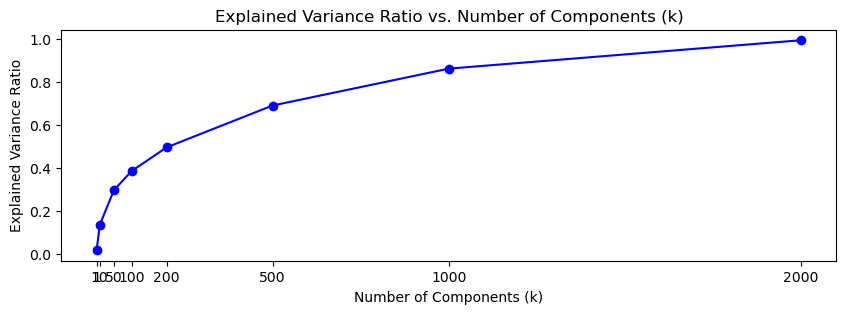

In [22]:
plt.figure(figsize=(10, 3))
plt.plot(k_values, exp_var, marker='o', linestyle='-', color='b')
plt.title('Explained Variance Ratio vs. Number of Components (k)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.xticks(k_values)
# plt.grid(True)
plt.show()


Initially, with a smaller number of components (k), each additional component contributes significantly to explaining the variance in the data. However, as k increases, the marginal gain in explained variance per additional component decreases (diminishing returns). The concavity of the plot suggests that adding more components beyond a certain point (elbow point) may not contribute significantly to capturing additional variance in the data. For instance, adding the first 1000 components has explained more than 80% of the variance while the second 1000 components just can add less than 20%.

### Q4-b 

**With k = 50 found in the previous sections, calculate the reconstruction residual MSE error
when using LSI and NMF – they both should use the same k = 50. Which one is larger, the
∥X−WH∥2 in NMF or the X−U Σ VT 2 in LSI and why?**

### Q4-b (answer)


In [23]:
# Reconstruct the original TF-IDF matrix using transformed components
X_reconstructed = np.dot(X_train_reduced, svd.components_)

# Compute the reconstruction residual error (RSS)
reconstruction_error_lsi = mean_squared_error(X_train_tfidf.toarray(), X_reconstructed)
print ('reconstruction residual MSE error from LSI:', reconstruction_error_lsi)


model = NMF(n_components=50, init='random', random_state=0)
W_train = model.fit_transform(X_train_tfidf)  # Matrix W (basis components)
H_train = model.components_       # Matrix H (coefficients)

# Reconstruct the original matrix X
X_reconstructed = np.dot(W_train, H_train)

# Compute the reconstruction error (RSS)
reconstruction_error_NMF = mean_squared_error(X_train_tfidf.toarray(), X_reconstructed)
print ('reconstruction residual MSE error from NMF:', reconstruction_error_NMF)


reconstruction residual MSE error from LSI: 4.4540803560970216e-05
reconstruction residual MSE error from NMF: 4.540287351906096e-05


The reconstruction error from NMF is slightly larger (1.7%) than that of the LSI. As the input matrix (TF-IDF) is expected to be non-negative, both methods are performing almost equal.

## Classification Algorithms

### QUESTION 5-a: 

**Compare and contrast hard-margin and soft-margin linear SVMs: • Train two linear SVMs:**

– **Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).**

– **Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?**


### Question5-a (answer):

In [24]:
y_train = np.array([1  if y=='climate' else 0 for y in train['root_label']])
y_test = np.array([1  if y=='climate' else 0 for y in test['root_label']])

In [25]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

In [26]:
# soft margin case (extreme regularization)
pipeline1 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=0.0001)),
])

pipeline1.fit(train['full_text'], y_train)


# hard margin case (No regularization)
pipeline2 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=1000)),
])

pipeline2.fit(train['full_text'], y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer=<function lemmatize_rmv_punc at 0x7f7da5acdcf0>,
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
                ('toarr', SparseToDenseArray()),
                ('clf', SVC(C=1000, kernel='linear'))])

In [27]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

#### soft margin case

accuracy on test: 0.47126436781609193
precision on test: 0.23563218390804597
recall on test: 0.5
F_score on test: 0.3203125
Confusion matrix on test: 
 [[  0 368]
 [  0 328]]


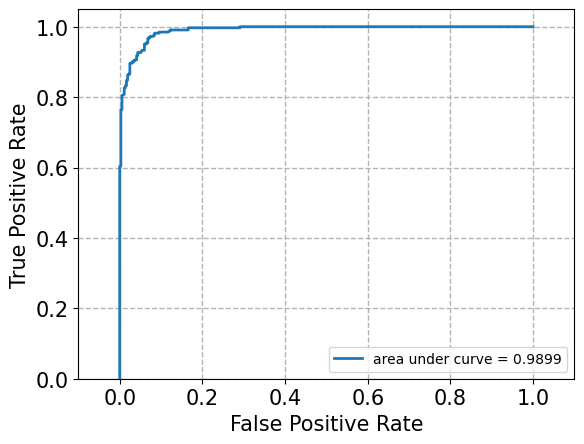

In [28]:
y_pred = pipeline1.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))


prob_score = pipeline1.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

#### hard margin case

accuracy on test: 0.9770114942528736
precision on test: 0.9765873015873017
recall on test: 0.9775980911983033
F_score on test: 0.9769627962399046
Confusion matrix on test: 
 [[356  12]
 [  4 324]]


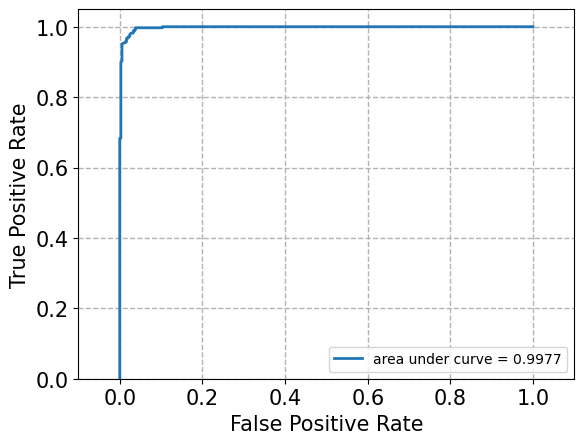

In [29]:
y_pred = pipeline2.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))

prob_score = pipeline2.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

- **What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.**

When we have soft margin the model is very lenient towards misclassification. When extreme soft margin like C=0.0001 is applied, the parameter vector w is highly penalized and pushed to zero. Accordingly the model is extremely regularized that it is not able to learn anything and underfit. As seen from the confusion matrix, with the defualt threshold of 0.5 the model is just predicting class 1 for all the examples and predicting wrong for all examples of class 0 (False positive of 368 for all examples of class 0).

However, when ROC is studied, a high level of area under curve shows that the model performs well. So, the interpretation for the low accuracy is just because of the threshold. Otherwise model has been able to separate the two classes as it is evident by ROC curve. 

- **Use cross-validation to choose γ. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.**

In [30]:
C_values = np.logspace(-3, 6, num=10, base=10.0)
accuracy_list = []
for C in C_values:
    pipeline1 = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', SVC(kernel='linear', C=C)),
    ])

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = cross_val_score(pipeline1, train['full_text'], y_train, cv=cv, scoring='accuracy')

    accuracy_list.append(np.mean(scores))

print(accuracy_list)
C_best_svm = C_values[np.argmax(accuracy_list)]
print (C_best_svm)

[0.4866906474820144, 0.6093525179856115, 0.9442446043165468, 0.9622302158273381, 0.970863309352518, 0.9701438848920863, 0.968705035971223, 0.968705035971223, 0.968705035971223, 0.968705035971223]
10.0


performance of the model when best C is used: 

accuracy on test: 0.978448275862069
precision on test: 0.9780248382538856
recall on test: 0.9792881760339343
F_score on test: 0.9784107946026986
Confusion matrix on test: 
 [[355  13]
 [  2 326]]


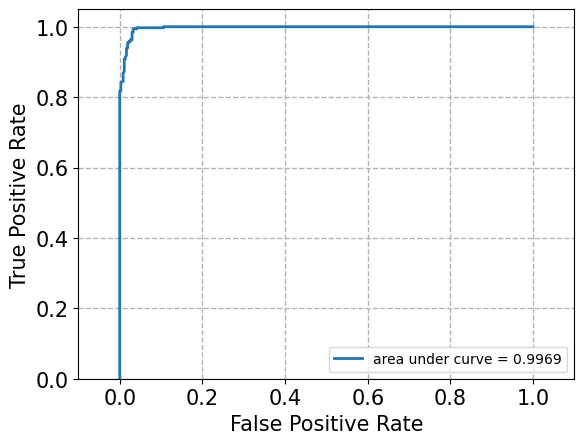

In [31]:
# SVM trained with best C (C_best_svm)
print('performance of the model when best C is used: \n')
pipeline1 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=C_best_svm)),
])

pipeline1.fit(train['full_text'], y_train)

y_pred = pipeline1.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))

prob_score = pipeline1.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

The best value of C is selected to be 10. The preformance of the trained model with this value on the test dataset is shown above. The accuracy is 97.8% with AOC ROC of 0.9969. As seen in the confusion matrix, 13 examples of sports class are misclassified as climate (False climate), and just 2 examples of climate are misclassified as Sports (False Sports).

### Logistic Classifier

### Q6-a

**Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.**

### Q6-a (answer):

logistic classifier W/o regularization:

accuracy on test: 0.9640804597701149
precision on test: 0.9638943872522631
recall on test: 0.9640442735949099
F_score on test: 0.9639673220886529
Confusion matrix on test: 
 [[355  13]
 [ 12 316]]


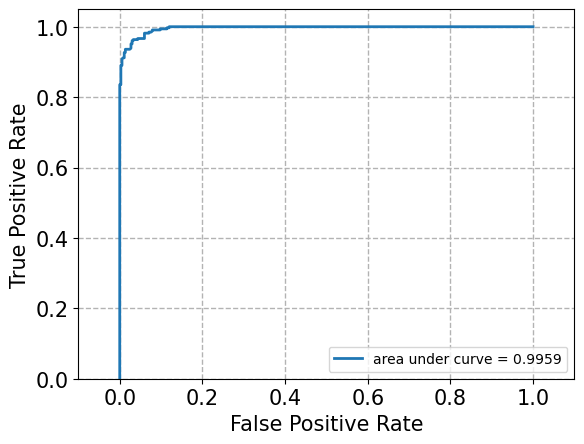

In [33]:
pipeline1 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty=None, random_state=0)),
])

pipeline1.fit(train['full_text'], y_train)

y_pred = pipeline1.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))

prob_score = pipeline1.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

### Q6-b1

**Find the optimal regularization coefficient:**

### Q6-b1 (answer):
**optimal regularization strength using 5-fold cross-validation for logistic regression with L1 regularization -->**

In [34]:
C_values = np.logspace(-5, 5, num=11, base=10.0)
accuracy_list_l1 = []
coefficients_l1_mean = []
feature_count_l1 = []
for C in C_values:
    pipeline1 = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', LogisticRegression(penalty='l1', solver='saga', C= C, random_state=0)),
    ])

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    cv_results = cross_validate(pipeline1, train['full_text'], y_train, cv=cv,\
                                scoring='accuracy', return_estimator=True)

    accuracy_list_l1.append(np.mean(cv_results['test_score']))
    coefficients_l1_mean.append(np.mean(np.abs(
        cv_results['estimator'][0].named_steps['clf'].coef_)))
    feature_count_l1.append(np.count_nonzero(
        cv_results['estimator'][0].named_steps['clf'].coef_))
    
print(accuracy_list_l1)
C_best_l1 = C_values[np.argmax(accuracy_list_l1)]
print (C_best_l1)

[0.5140287769784173, 0.5140287769784173, 0.5140287769784173, 0.4866906474820144, 0.9241007194244604, 0.9460431654676258, 0.956115107913669, 0.956474820143885, 0.9571942446043165, 0.9571942446043165, 0.9571942446043165]
1000.0


**optimal regularization strength using 5-fold cross-validation for logistic regression with L2 regularization -->**

In [35]:
C_values = np.logspace(-5, 5, num=11, base=10.0)
accuracy_list_l2 = []
coefficients_l2_mean = []
feature_count_l2 = []
for C in C_values:
    pipeline1 = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', LogisticRegression(penalty='l2', C= C, random_state=0)),
    ])

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    cv_results2 = cross_validate(pipeline1, train['full_text'], y_train, cv=cv, scoring='accuracy', return_estimator=True)

    accuracy_list_l2.append(np.mean(cv_results2['test_score']))
    coefficients_l2_mean.append(np.mean(np.abs(cv_results2['estimator'][0].named_steps['clf'].coef_)))
    feature_count_l2.append(np.count_nonzero(cv_results2['estimator'][0].named_steps['clf'].coef_))
    
print(accuracy_list_l2)
C_best_l2 = C_values[np.argmax(accuracy_list_l2)]
print (C_best_l2)

[0.4866906474820144, 0.5179856115107914, 0.7971223021582733, 0.9223021582733812, 0.9345323741007194, 0.9485611510791367, 0.9550359712230216, 0.956115107913669, 0.9557553956834532, 0.9568345323741008, 0.9568345323741008]
10000.0


Per the results of two above cells, the optimal regularization strength using 5-fold cross-validation for logistic regression with L1 and L2 regularization is 1000 and 10000 respectively.

### Q6-b2

**Comparison of 3 logistic classifiers, w/o regularization, L1, and L2 regularization -->**

### Q6-b2 (answer)


logistic classifier without regularization:
accuracy on test: 0.9640804597701149
precision on test: 0.9638943872522631
recall on test: 0.9640442735949099
F_score on test: 0.9639673220886529
Confusion matrix on test: 
 [[355  13]
 [ 12 316]]


--------------------
logistic classifier with L1 regularization and best C:
accuracy on test: 0.9626436781609196
precision on test: 0.9623944361649279
recall on test: 0.9626855779427359
F_score on test: 0.9625319894320996
Confusion matrix on test: 
 [[354  14]
 [ 12 316]]


--------------------
logistic classifier with L2 regularization and best C:
accuracy on test: 0.9640804597701149
precision on test: 0.9638943872522631
recall on test: 0.9640442735949099
F_score on test: 0.9639673220886529
Confusion matrix on test: 
 [[355  13]
 [ 12 316]]


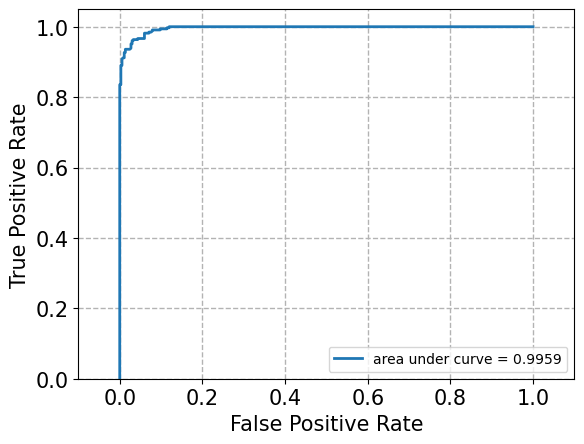

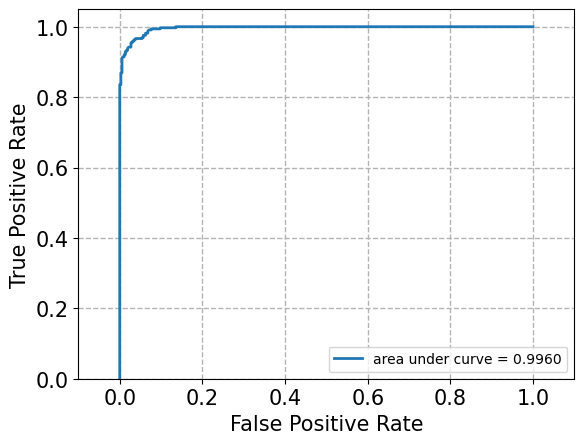

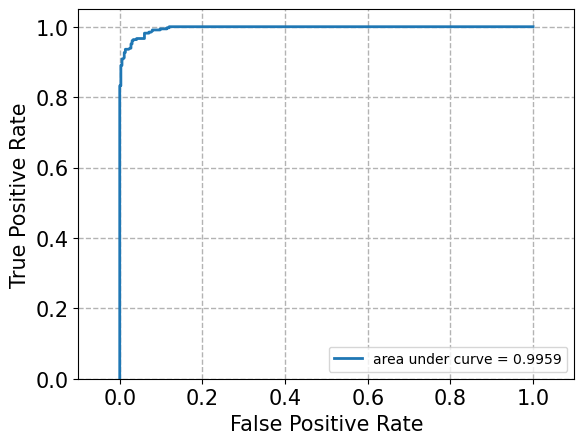

In [36]:
print("logistic classifier without regularization:")

pipeline1 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty=None, random_state=0)),
])

pipeline1.fit(train['full_text'], y_train)

y_pred = pipeline1.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))

prob_score = pipeline1.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

print ('\n')
print ('-'*20)
#  =============================
#  =============================
#  =============================
print("logistic classifier with L1 regularization and best C:")

pipeline1 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', C= C_best_l1, random_state=0)),
])

pipeline1.fit(train['full_text'], y_train)

y_pred = pipeline1.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))

prob_score = pipeline1.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

print ('\n')
print ('-'*20)
#  =============================
#  =============================
#  =============================
print("logistic classifier with L2 regularization and best C:")

pipeline2 = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(penalty='l2', C= C_best_l2, random_state=0)),
])

pipeline2.fit(train['full_text'], y_train)

y_pred = pipeline2.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))

prob_score = pipeline2.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

### Q6-b3
- **How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?**

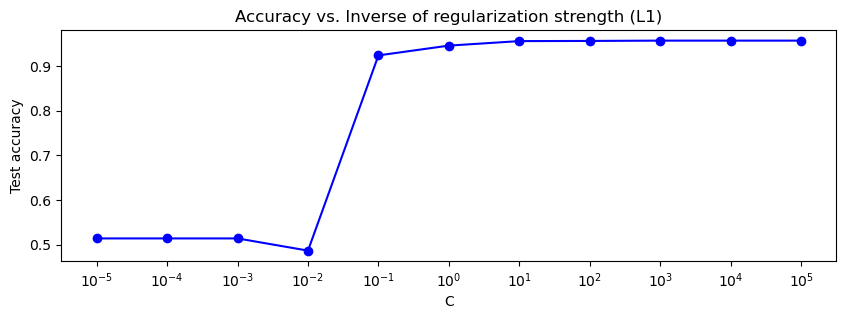

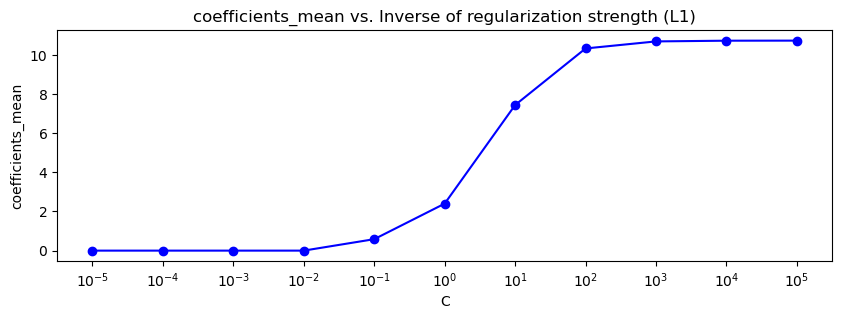

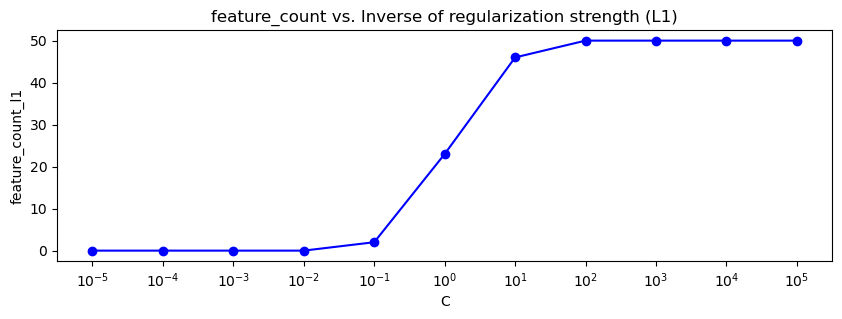

In [37]:
plt.figure(figsize=(10, 3))
plt.semilogx(C_values, accuracy_list_l1, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Inverse of regularization strength (L1)')
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.xticks(C_values)
# plt.grid(True)

plt.figure(figsize=(10, 3))
plt.semilogx(C_values, coefficients_l1_mean, marker='o', linestyle='-', color='b')
plt.title('coefficients_mean vs. Inverse of regularization strength (L1)')
plt.xlabel('C')
plt.ylabel('coefficients_mean')
plt.xticks(C_values)

plt.figure(figsize=(10, 3))
plt.semilogx(C_values, feature_count_l1, marker='o', linestyle='-', color='b')
plt.title('feature_count vs. Inverse of regularization strength (L1)')
plt.xlabel('C')
plt.ylabel('feature_count_l1')
plt.xticks(C_values)
plt.show()

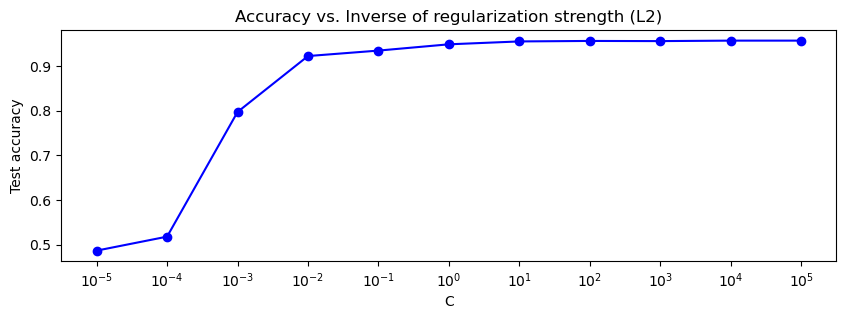

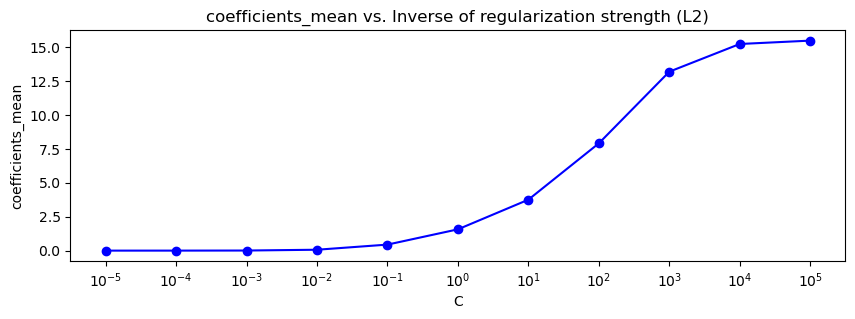

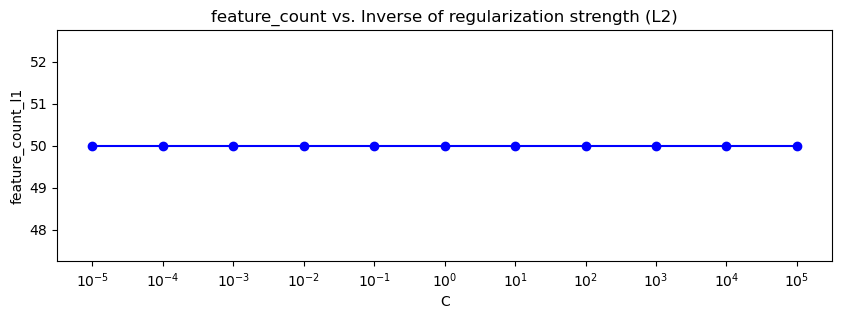

In [38]:
plt.figure(figsize=(10, 3))
plt.semilogx(C_values, accuracy_list_l2, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Inverse of regularization strength (L2)')
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.xticks(C_values)
# plt.grid(True)

plt.figure(figsize=(10, 3))
plt.semilogx(C_values, coefficients_l2_mean, marker='o', linestyle='-', color='b')
plt.title('coefficients_mean vs. Inverse of regularization strength (L2)')
plt.xlabel('C')
plt.ylabel('coefficients_mean')
plt.xticks(C_values)

plt.figure(figsize=(10, 3))
plt.semilogx(C_values, feature_count_l2, marker='o', linestyle='-', color='b')
plt.title('feature_count vs. Inverse of regularization strength (L2)')
plt.xlabel('C')
plt.ylabel('feature_count_l1')
plt.xticks(C_values)
plt.show()

### Q6-b3 (answer)

Observation on effect of the regularization parameter on test error, coefficient:

As seen from the above plots, by increasing the regularization strength extensively (too small C) model is not able to learn from the avaialable dataset, and therefore performance on the test data deteriorate.

The learnt coefficients get smaller as regularization get stronger (smaller C) as shown in graphs for both regularization methods which plots the average of the absolute of the coefficients. Also, as shown in the third graph, l1 regularization has led to shrinkage of the feature count while l2 does not have such effect.

- **Why might one be interested in each type of regularization?**

l1 regularization results in sparsity by driving irrelevant or less important features' coefficients to exactly zero as shown in above plots. In other words, it automatically performs feature selection, which can be highly beneficial for high-dimensional datasets with many potentially irrelevant features. However, when dealing with datasets where most features are expected to contribute to the prediction, L2 regularization can be more suitable and efficient. In this case regularizer is aimed to just prevent overfitting rather than automatic feature selection.

### Q6-b4

- **Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary?  Is this difference statistically significant?**

Logistic regression minimizes the logistic loss (or cross-entropy loss), which measures the difference between predicted probabilities and true labels. Later, it uses gradient descent or other optimization algorithms to find the weights (coefficients) that minimize the logistic loss. On the other hand, Linear Support Vector Machines (SVM)aims to find the maximum-margin hyperplane that separates the classes. It minimizes the hinge loss, penalizing misclassified examples. Thereafter, SVM optimization involves maximizing the margin between the closest points (support vectors) from different classes. This is typically done using quadratic programming or convex optimization techniques.

- **Why do their performances differ?**

SVM is generally less sensitive to outliers due to its reliance on support vectors, which are only influenced by the data points closest to the decision boundary. On the other hand, Logistic regression can be more influenced by outliers because it directly minimizes the impact of misclassifications on all data points (classification error).

- **Is this difference statistically significant?**

Since their formulations are different, their results are not comparable.

## Naive Bayes Model

### Question 7
- **Evaluate and profile a Na ̈ıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.**

### Q7 (answer)


accuracy on test: 0.7844827586206896
precision on test: 0.8256226355611602
recall on test: 0.7738268822905621
F_score on test: 0.7724578044357651
Confusion matrix on test: 
 [[353  15]
 [135 193]]


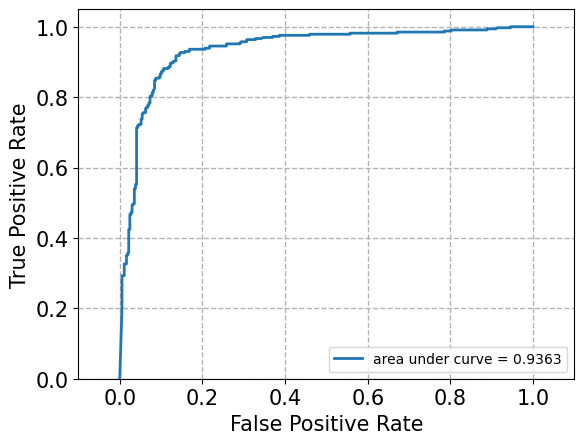

In [39]:
pipeline_GNB = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', GaussianNB()),
])
pipeline_GNB.fit(train['full_text'], y_train)

y_pred = pipeline_GNB.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))


prob_score = pipeline_GNB.predict_proba(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score[:,1])

plot_roc(fpr, tpr)

accuracy on test: 0.9482758620689655
precision on test: 0.9479880774962741
recall on test: 0.9482701484623541
F_score on test: 0.9481212161367532
Confusion matrix on test: 
 [[349  19]
 [ 17 311]]


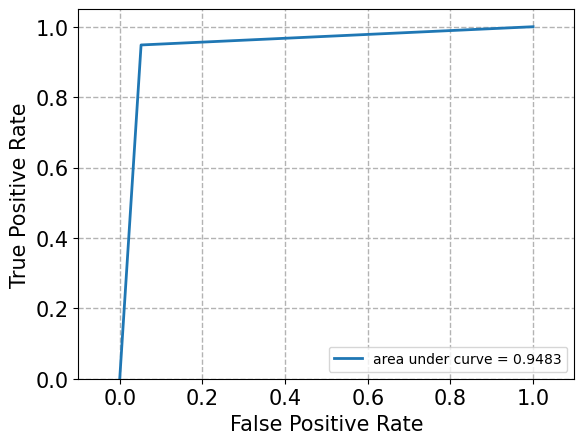

In [40]:
# Since gaussianNB classifier doesn't work well with sparse data, 
# I don't use reduced dimension here

pipeline_GNB = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('toarr', SparseToDenseArray()),
    ('clf', GaussianNB()),
])
pipeline_GNB.fit(train['full_text'], y_train)

y_pred = pipeline_GNB.predict(test['full_text'])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))


prob_score = pipeline_GNB.predict_proba(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score[:,1])

plot_roc(fpr, tpr)

## Grid Search



In [41]:
C_best_svm = 100

In [42]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', SVC(kernel='poly')),
    ])


Min_DF_OPTIONS = [3, 5]
COMPRESSION_OPTIONS = [lemmatize_rmv_punc, stemmed_words]
DimRed_OPTIONS = [TruncatedSVD(), NMF()]
N_FEATURES_OPTIONS = [5, 30, 80]

CLF_OPTIONS = [SVC(), LogisticRegression()]
C_OPTIONS = [0.1, 1, 10]
KERNEL_OPTIONS = ['linear', 'rbf']
REG_OPTIONS = ['l1', 'l2']
# REG_STRENGTH_OPTIONS = [0.1, 1, 10]

param_grid = [
    {
        'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        
        'clf': [SVC(C = C_best_svm)],
        'clf__kernel': KERNEL_OPTIONS,
        'clf__gamma': [0.001, 0.0001]
        
    },
    
    {
        'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        
        'clf': [LogisticRegression(C= 100)],
        'clf__penalty': REG_OPTIONS,
    },
    
    {
        'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        
        'clf': [GaussianNB()],

    },
]
# reducer_labels = ['LinearSVC', 'NMF', 'KBest(chi2)']

# grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy', verbose=1)
# grid.fit(train['full_text'][:100], y_train[:100])

In [44]:
# pd.DataFrame(grid.cv_results_)

### Question 8
- **In this part, you will attempt to find the best model for binary classification.**

In [51]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=3, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [60]:
pipeline_svm = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', SVC(kernel='poly')),
    ])

pipeline_log = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', LogisticRegression()),
    ])

pipeline_NB = Pipeline([
        ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=500, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', GaussianNB()),
    ])


Min_DF_OPTIONS = [3, 5]
COMPRESSION_OPTIONS = [lemmatize_rmv_punc, stemmed_words]
DimRed_OPTIONS = [TruncatedSVD(), NMF()]
N_FEATURES_OPTIONS = [5, 30, 80]

C_OPTIONS = [0.1, 1, 10]
REG_OPTIONS = ['l1', 'l2']


models1 = {
    'SVC': pipeline_svm,
    'LogisticClassifier': pipeline_log,
    'NaiveBayesClassifier': pipeline_NB
}

params1 = {
    'SVC': [
        {'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': [500],
        'clf__kernel': ['linear'], 
        'clf__C': [C_best_svm]},
        
        {'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': [500],
        'clf__kernel': ['rbf'], 
        'clf__C': [C_best_svm], 
        'clf__gamma': [0.001, 0.0001]},
    ],
    'LogisticClassifier': 
        {'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': N_FEATURES_OPTIONS, 
        'clf__penalty': REG_OPTIONS,
        'clf__C': [C_best_l1, C_best_l1]},
    
    'NaiveBayesClassifier': 
        {'vect__min_df': Min_DF_OPTIONS, 
        'vect__analyzer': COMPRESSION_OPTIONS,
        'reduce_dim': DimRed_OPTIONS, 
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
         }
    
}


helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(train['full_text'], y_train, scoring='f1', n_jobs=2)

In [57]:
helper1.score_summary(sort_by='mean_score')

SVC
LogisticClassifier
NaiveBayesClassifier


,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__kernel,reduce_dim,reduce_dim__n_components,vect__analyzer,vect__min_df,clf__gamma,clf__penalty
0,SVC,0.959436,0.965093,0.975177,0.005368,100,linear,TruncatedSVD(n_components=80),500,<function lemmatize_rmv_punc at 0x7f7da5acdcf0>,3,NaN,NaN
3,SVC,0.957447,0.965012,0.973357,0.00566,100,linear,TruncatedSVD(n_components=80),500,<function stemmed_words at 0x7f7da5acdc60>,5,NaN,NaN
2,SVC,0.950704,0.963998,0.973166,0.007813,100,linear,TruncatedSVD(n_components=80),500,<function stemmed_words at 0x7f7da5acdc60>,3,NaN,NaN
1,SVC,0.957447,0.962844,0.969697,0.004665,100,linear,TruncatedSVD(n_components=80),500,<function lemmatize_rmv_punc at 0x7f7da5acdcf0>,5,NaN,NaN
105,LogisticClassifier,0.951699,0.960913,0.970018,0.006705,1000.0,NaN,TruncatedSVD(n_components=80),80,<function lemmatize_rmv_punc at 0x7f7da5acdcf0>,5,NaN,l2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,LogisticClassifier,NaN,NaN,NaN,NaN,1000.0,NaN,NMF(n_components=80),30,<function stemmed_words at 0x7f7da5acdc60>,5,NaN,l1
92,LogisticClassifier,NaN,NaN,NaN,NaN,1000.0,NaN,NMF(n_components=80),80,<function lemmatize_rmv_punc at 0x7f7da5acdcf0>,3,NaN,l1
93,LogisticClassifier,NaN,NaN,NaN,NaN,1000.0,NaN,NMF(n_components=80),80,<function lemmatize_rmv_punc at 0x7f7da5acdcf0>,5,NaN,l1
94,LogisticClassifier,NaN,NaN,NaN,NaN,1000.0,NaN,NMF(n_components=80),80,<function stemmed_words at 0x7f7da5acdc60>,3,NaN,l1


### Question 8 (answer)
- **What are the 5 best combinations? Report their performances on the testing set.**

the 5 best combinations are:

1- Lemmatize + (min_df = 3) + TruncatedSVD() with k= 500 + SVC (linear) (C=100)  

2- Stemming + (min_df = 5) + TruncatedSVD() with k= 500 + SVC (linear) (C=100)

3- Stemming + (min_df = 3) + TruncatedSVD() with k= 500 + SVC (linear) (C=100)

4- Lemmatize+ (min_df = 5) + TruncatedSVD() with k= 500 + SVC (linear) (C=100)

5- Lemmatize (min_df = 5) + TruncatedSVD()  with k= 80 + Logistic (l2) (C=1000)


Performance on the test set for the 5 best combination:

SVC
LogisticClassifier
NaiveBayesClassifier
Model 'SVC' Test Score: 0.9728915662650602
Model 'SVC' Test Score: 0.9728915662650602
Model 'SVC' Test Score: 0.9728915662650602
Model 'SVC' Test Score: 0.9728915662650602
Model 'LogisticClassifier' Test Score: 0.9715142428785606


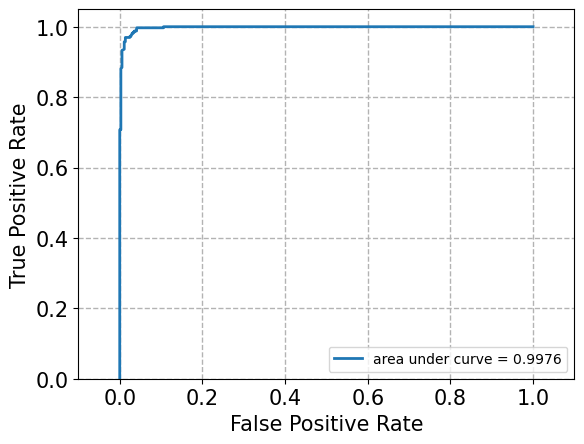

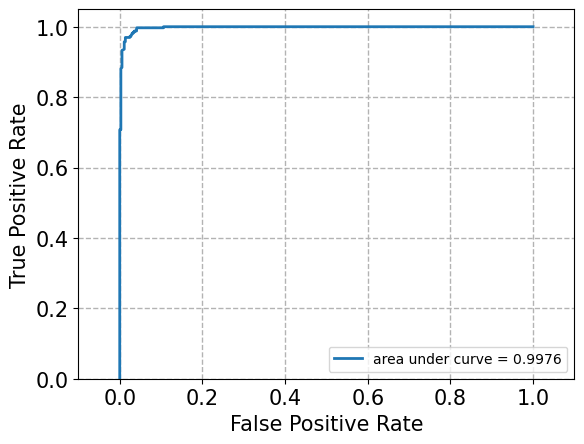

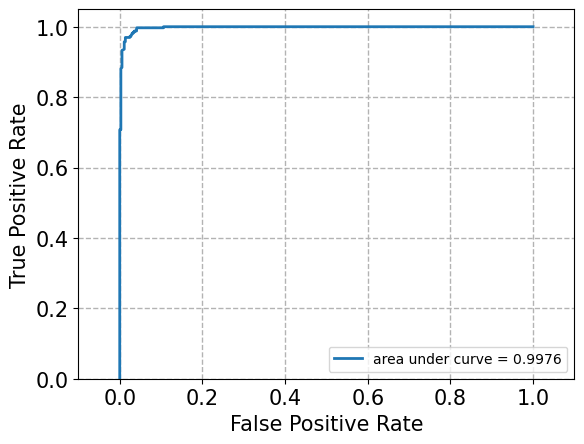

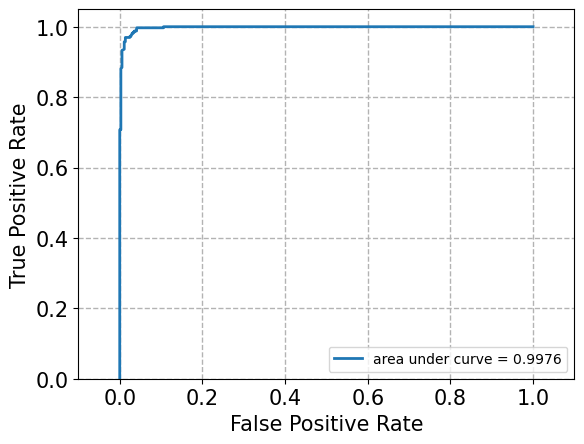

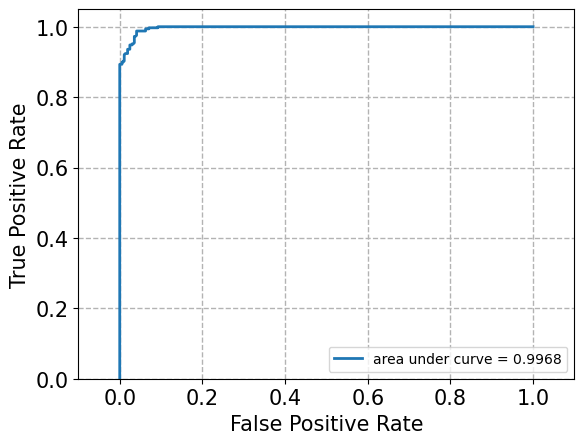

In [61]:
# Get the best 5 models based on mean_score 
best_models_summary = helper1.score_summary(sort_by='mean_score')
best_models = best_models_summary.head(5)['estimator'].tolist()

# Retrieve the best GridSearchCV objects (estimators) from helper1
best_estimators = [helper1.grid_searches[model] for model in best_models]

# Evaluate the best models on the test data
test_scores = []
for gs in best_estimators:
    test_score = gs.score(test['full_text'], y_test) 
    test_scores.append(test_score)
    
    try:
        prob_score = gs.best_estimator_.decision_function(test['full_text'])
        fpr, tpr, _ = roc_curve(y_test, prob_score)

        plot_roc(fpr, tpr)
    except Exception as e:
        print(f"Error predicting with model: {e}")
# Display the test scores for the best models
for model, score in zip(best_models, test_scores):
    print(f"Model '{model}' Test Score: {score}")




## Multiclass Classification


In [62]:
map_class_to_num = {'basketball': 0, 'baseball': 1, 'tennis': 2, 'football': 3,\
                    'soccer': 4, 'forest fire': 5, 'flood': 6, 'earthquake': 7,\
                    'drought': 8, 'heatwave': 9}
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
                    3:"football", 4:"soccer", 5:"forest fire", 6:"flood",
                    7:"earthquake", 8:"drought", 9:"heatwave"}

y_train_multi = np.array([map_class_to_num[y] for y in train['leaf_label']])
y_test_multi = np.array([map_class_to_num[y] for y in test['leaf_label']])

### Question 9
 - **Na ̈ıve Bayes classification:**

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

pipeline_NB = Pipeline([
        ('vect', CountVectorizer(min_df=3, analyzer=lemmatize_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', NMF(n_components=50, random_state=0)),
        ('toarr', SparseToDenseArray()),
        ('clf', MultinomialNB()),
    ])

# Train the classifier
pipeline_NB.fit(train['full_text'], y_train_multi)

# Predict on the test set
y_pred = pipeline_NB.predict(test['full_text'])

target_names = [map_row_to_class[i] for i in range(10)]

# Evaluate performance
accuracy = accuracy_score(y_test_multi, y_pred)
print("Accuracy:", accuracy)

print ('precision on test:', precision_score(y_test_multi, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi, y_pred))



# Generate classification report
report = classification_report(y_test_multi, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.7126436781609196
precision on test: 0.7473015957595306
recall on test: 0.7208476216707901
F_score on test: 0.712154274050816
Confusion matrix on test: 
 [[65  1 13  9  0  0  0  0  0  2]
 [ 0 54  7  3  0  0  2  0  1  8]
 [ 0  7 55  1  1  0  4  1  0  0]
 [ 0  0  4 56  1  0  0  0  0  0]
 [ 0  1  5  7 60  0  0  0  0  0]
 [ 0  0  5  1  1  9  0  1  4 52]
 [ 0  0  1  0  0  0 62  0  0  3]
 [ 0  0  3  2  0  0  1 45  0  3]
 [ 0  0  3  1  0  0  3  0 46 15]
 [ 0  0  6  0  0 13  3  0  1 44]]
Classification Report:
               precision    recall  f1-score   support

  basketball       1.00      0.72      0.84        90
    baseball       0.86      0.72      0.78        75
      tennis       0.54      0.80      0.64        69
    football       0.70      0.92      0.79        61
      soccer       0.95      0.82      0.88        73
 forest fire       0.41      0.12      0.19        73
       flood       0.83      0.94      0.88        66
  earthquake       0.96      0.83      0.89    

 - **SVM (one vs one):**

In [64]:
# SVM (one vs one)
pipeline_SVM_OVO = Pipeline([
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=200, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=10000, class_weight = 'balanced')),
])


pipeline_SVM_OVO.fit(train['full_text'], y_train_multi)

# Predict on the test set
y_pred = pipeline_SVM_OVO.predict(test['full_text'])

# Evaluate performance
accuracy = accuracy_score(y_test_multi, y_pred)
print("Accuracy:", accuracy)
print ('precision on test:', precision_score(y_test_multi, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi, y_pred))

target_names = [map_row_to_class[i] for i in range(10)]
# Generate classification report
report = classification_report(y_test_multi, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.757183908045977
precision on test: 0.7679674265996945
recall on test: 0.7575634155451737
F_score on test: 0.7621873802396735
Confusion matrix on test: 
 [[87  1  0  2  0  0  0  0  0  0]
 [ 1 67  2  0  1  3  0  0  1  0]
 [ 0  4 59  0  1  1  1  0  1  2]
 [ 0  0  1 60  0  0  0  0  0  0]
 [ 0  3  1  2 67  0  0  0  0  0]
 [ 0  1  0  0  1  7  0  1  3 60]
 [ 0  2  0  0  0  3 61  0  0  0]
 [ 0  1  1  0  1  1  0 49  1  0]
 [ 0  0  0  0  0  4  0  0 60  4]
 [ 0  2  0  0  1 52  1  0  1 10]]
Classification Report:
               precision    recall  f1-score   support

  basketball       0.99      0.97      0.98        90
    baseball       0.83      0.89      0.86        75
      tennis       0.92      0.86      0.89        69
    football       0.94      0.98      0.96        61
      soccer       0.93      0.92      0.92        73
 forest fire       0.10      0.10      0.10        73
       flood       0.97      0.92      0.95        66
  earthquake       0.98      0.91      0.94    

In [65]:
# # SVM (one vs one)
# pipeline_SVM_OVO = Pipeline([
#     ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
#     ('tfidf', TfidfTransformer()),
#     ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
#     ('toarr', SparseToDenseArray()),
#     ('clf', SVC(kernel='linear', C=10000, class_weight = 'balanced')),
# ])


# param_grid = [
#     {
# #         'vect__min_df': Min_DF_OPTIONS, 
# #         'vect__analyzer': COMPRESSION_OPTIONS,
        
# #         'reduce_dim': DimRed_OPTIONS, 
# #         'reduce_dim__n_components': N_FEATURES_OPTIONS,
        
# #         'clf__kernel': KERNEL_OPTIONS,
#         'clf__C': [0.001, 0.01, 0.03, 0.1, 0.3, 1, 10, 100]
        
#     }
# ]

# grid_SVM_OVO = GridSearchCV(pipeline_SVM_OVO, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy', verbose=1)


# grid_SVM_OVO.fit(train['full_text'], y_train_multi)

# # Predict on the test set
# y_pred = grid_SVM_OVO.best_estimator_.predict(test['full_text'])
# print('best params are:',grid_SVM_OVO.best_params_)

# # Evaluate performance
# accuracy = accuracy_score(y_test_multi, y_pred)
# print("Accuracy:", accuracy)

# target_names = [map_row_to_class[i] for i in range(10)]
# # Generate classification report
# report = classification_report(y_test_multi, y_pred, target_names=target_names)
# print("Classification Report:\n", report)


 - **LinearSVM (one vs rest):**

In [66]:
# LinearSVM (one vs rest)
pipeline_SVM_OVR = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=200, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LinearSVC(C=0.1, class_weight = 'balanced', dual='auto')),
])

pipeline_SVM_OVR.fit(train['full_text'], y_train_multi)

# Predict on the test set
y_pred = pipeline_SVM_OVR.predict(test['full_text'])

# Evaluate performance
accuracy = accuracy_score(y_test_multi, y_pred)
print("Accuracy:", accuracy)
print ('precision on test:', precision_score(y_test_multi, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi, y_pred))

target_names = [map_row_to_class[i] for i in range(10)]
# Generate classification report
report = classification_report(y_test_multi, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.7902298850574713
precision on test: 0.7815795730208934
recall on test: 0.7915275441614283
F_score on test: 0.7854452751193148
Confusion matrix on test: 
 [[86  0  2  2  0  0  0  0  0  0]
 [ 0 65  3  2  0  2  2  0  1  0]
 [ 0  6 60  0  0  0  2  0  0  1]
 [ 0  0  0 61  0  0  0  0  0  0]
 [ 1  2  1  2 67  0  0  0  0  0]
 [ 0  3  2  0  1 20  1  1  6 39]
 [ 0  1  0  0  0  1 64  0  0  0]
 [ 0  2  0  0  0  1  0 50  0  1]
 [ 0  1  0  0  0  1  0  0 60  6]
 [ 0  4  2  0  1 37  4  0  2 17]]
Classification Report:
               precision    recall  f1-score   support

  basketball       0.99      0.96      0.97        90
    baseball       0.77      0.87      0.82        75
      tennis       0.86      0.87      0.86        69
    football       0.91      1.00      0.95        61
      soccer       0.97      0.92      0.94        73
 forest fire       0.32      0.27      0.30        73
       flood       0.88      0.97      0.92        66
  earthquake       0.98      0.93      0.95   

-  **Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?**

All three models perform poor on classifying the 'forest fire' and 'heatwave' also  'drought' and 'heatwave' asis  evident from the large number of off-diagonal non-zeros corresponding to these two pairs. For instance, 39 examples of 'forest fire' subclass and 6 examples of 'drought' subclass are predicted as 'heatwave' subclass. On the other hand, 37 and 2 examples of 'heatwave' subclass are predicted as 'forest fire' and 'dought' respectively. This is also shown by lower recall and precision values for the mentioned subclasses.

- **Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?**

In the below cell, I am going to merge the 'forest fire', 'heatwave', and 'drought' and train a model based on that-->

In [145]:
map_class_to_num = {'basketball': 0, 'baseball': 1, 'tennis': 2, 'football': 3,\
                    'soccer': 4, 'forest fire': 5, 'flood': 6, 'earthquake': 7,\
                    'drought': 5, 'heatwave': 5}
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
                    3:"football", 4:"soccer", 5:"heatwave_merged", 6:"flood",
                    7:"earthquake"}

y_train_multi_merged = np.array([map_class_to_num[y] for y in train['leaf_label']])
y_test_multi_merged = np.array([map_class_to_num[y] for y in test['leaf_label']])

In [158]:
# SVM (one vs one)
pipeline_SVM_OVO_merged = Pipeline([
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=200, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=10000)),
    
])


pipeline_SVM_OVO_merged.fit(train['full_text'], y_train_multi_merged)

# Predict on the test set
y_pred = pipeline_SVM_OVO_merged.predict(test['full_text'])

# Evaluate performance
accuracy = accuracy_score(y_test_multi_merged, y_pred)
print("Accuracy:", accuracy)
print ('precision on test:', precision_score(y_test_multi_merged, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi_merged, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi_merged, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi_merged, y_pred))

target_names = [map_row_to_class[i] for i in range(8)]
# Generate classification report
report = classification_report(y_test_multi_merged, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.9295977011494253
precision on test: 0.930460284377708
recall on test: 0.9210085386545566
F_score on test: 0.9251203186365529
Confusion matrix on test: 
 [[ 87   1   0   2   0   0   0   0]
 [  1  65   2   0   1   6   0   0]
 [  0   3  59   0   1   4   2   0]
 [  0   1   1  59   0   0   0   0]
 [  0   4   0   2  66   1   0   0]
 [  0   3   0   0   2 200   2   1]
 [  0   2   0   0   0   2  62   0]
 [  0   1   1   0   1   1   1  49]]
Classification Report:
                  precision    recall  f1-score   support

     basketball       0.99      0.97      0.98        90
       baseball       0.81      0.87      0.84        75
         tennis       0.94      0.86      0.89        69
       football       0.94      0.97      0.95        61
         soccer       0.93      0.90      0.92        73
heatwave_merged       0.93      0.96      0.95       208
          flood       0.93      0.94      0.93        66
     earthquake       0.98      0.91      0.94        54

       accuracy

In [157]:
# LinearSVM (one vs rest)
pipeline_SVM_OVR_merged = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=200, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LinearSVC(C=0.1, dual='auto')),
    
])

pipeline_SVM_OVR_merged.fit(train['full_text'], y_train_multi_merged)

# Predict on the test set
y_pred = pipeline_SVM_OVR_merged.predict(test['full_text'])

# Evaluate performance
accuracy = accuracy_score(y_test_multi_merged, y_pred)
print("Accuracy:", accuracy)
print ('precision on test:', precision_score(y_test_multi_merged, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi_merged, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi_merged, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi_merged, y_pred))

target_names = [map_row_to_class[i] for i in range(8)]
# Generate classification report
report = classification_report(y_test_multi_merged, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.896551724137931
precision on test: 0.9301615426571939
recall on test: 0.8752047993642693
F_score on test: 0.89680620400827
Confusion matrix on test: 
 [[ 85   0   0   2   0   3   0   0]
 [  0  52   3   2   0  17   1   0]
 [  0   4  52   0   0  11   2   0]
 [  0   0   0  61   0   0   0   0]
 [  1   1   1   2  65   3   0   0]
 [  0   0   0   0   1 204   3   0]
 [  0   0   0   0   0   5  61   0]
 [  0   0   0   0   0  10   0  44]]
Classification Report:
                  precision    recall  f1-score   support

     basketball       0.99      0.94      0.97        90
       baseball       0.91      0.69      0.79        75
         tennis       0.93      0.75      0.83        69
       football       0.91      1.00      0.95        61
         soccer       0.98      0.89      0.94        73
heatwave_merged       0.81      0.98      0.89       208
          flood       0.91      0.92      0.92        66
     earthquake       1.00      0.81      0.90        54

       accuracy  

As shown in the results, the accuracy of One vs One is increased from 0.75 to 0.92. Also, the accuracy of the One vs Rest is increased from 0.79 to 0.89. As shown in the confusion matrix (above), the number of off-diagonal non zeros is reduced, especially in the case of One vs One.

- <font size="4">**Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.**


Yes for One vs Rest. Class imbalance, large number of examples for the merged class, affect the performance adversely. However, this can be remedied by adjusting the weight of each examples according to the population of the class to which the examples belongs. Below cells apply this modification by using 'balnced' class_weight as The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. 

This is not an issue for One vs One as it inherently adjust the weight of each example according to the population ratio for each classifier that it considers.


In [156]:
# SVM (one vs one)
pipeline_SVM_OVO_merged = Pipeline([
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=200, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=10000, class_weight = 'balanced')),
#     ('clf', SVC(kernel='linear', C=10000)),
    
])


pipeline_SVM_OVO_merged.fit(train['full_text'], y_train_multi_merged)

# Predict on the test set
y_pred = pipeline_SVM_OVO_merged.predict(test['full_text'])

# Evaluate performance
accuracy = accuracy_score(y_test_multi_merged, y_pred)
print("Accuracy:", accuracy)
print ('precision on test:', precision_score(y_test_multi_merged, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi_merged, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi_merged, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi_merged, y_pred))

target_names = [map_row_to_class[i] for i in range(8)]
# Generate classification report
report = classification_report(y_test_multi_merged, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.9281609195402298
precision on test: 0.9306789837770977
recall on test: 0.9193418719878899
F_score on test: 0.9243448661971968
Confusion matrix on test: 
 [[ 87   1   0   2   0   0   0   0]
 [  1  64   2   0   1   7   0   0]
 [  0   4  59   0   1   4   1   0]
 [  0   1   1  59   0   0   0   0]
 [  0   4   0   2  66   1   0   0]
 [  0   3   0   0   2 200   2   1]
 [  0   2   0   0   0   2  62   0]
 [  0   2   1   0   1   1   0  49]]
Classification Report:
                  precision    recall  f1-score   support

     basketball       0.99      0.97      0.98        90
       baseball       0.79      0.85      0.82        75
         tennis       0.94      0.86      0.89        69
       football       0.94      0.97      0.95        61
         soccer       0.93      0.90      0.92        73
heatwave_merged       0.93      0.96      0.95       208
          flood       0.95      0.94      0.95        66
     earthquake       0.98      0.91      0.94        54

       accurac

In [155]:
# LinearSVM (one vs rest)
pipeline_SVM_OVR_merged = Pipeline([
    ('vect', CountVectorizer(min_df=1, analyzer=lemmatize_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=200, random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', LinearSVC(C=0.1, class_weight = 'balanced', dual='auto')),
#     ('clf', LinearSVC(C=0.1, dual='auto')),
    
])

pipeline_SVM_OVR_merged.fit(train['full_text'], y_train_multi_merged)

# Predict on the test set
y_pred = pipeline_SVM_OVR_merged.predict(test['full_text'])

# Evaluate performance
accuracy = accuracy_score(y_test_multi_merged, y_pred)
print("Accuracy:", accuracy)
print ('precision on test:', precision_score(y_test_multi_merged, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test_multi_merged, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test_multi_merged, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test_multi_merged, y_pred))

target_names = [map_row_to_class[i] for i in range(8)]
# Generate classification report
report = classification_report(y_test_multi_merged, y_pred, target_names=target_names)
print("Classification Report:\n", report)


Accuracy: 0.9252873563218391
precision on test: 0.9266452567100318
recall on test: 0.9171777112745068
F_score on test: 0.9212565882344167
Confusion matrix on test: 
 [[ 86   0   2   2   0   0   0   0]
 [  0  62   3   2   0   7   1   0]
 [  0   6  59   0   0   2   2   0]
 [  0   1   0  60   0   0   0   0]
 [  1   2   1   1  68   0   0   0]
 [  0   3   1   0   1 199   3   1]
 [  0   1   0   0   0   3  62   0]
 [  0   2   0   0   0   4   0  48]]
Classification Report:
                  precision    recall  f1-score   support

     basketball       0.99      0.96      0.97        90
       baseball       0.81      0.83      0.82        75
         tennis       0.89      0.86      0.87        69
       football       0.92      0.98      0.95        61
         soccer       0.99      0.93      0.96        73
heatwave_merged       0.93      0.96      0.94       208
          flood       0.91      0.94      0.93        66
     earthquake       0.98      0.89      0.93        54

       accurac

According to the results form above cells which are after applying the weight adjustment according to population ratio, performance of the One vs Rest has increased to 0.92 which was previously 0.89. Also, the confusion matrix shows that the number of off-diagonal non-zero elements are singnificantly decreased.

## GLoVE
### Question 10 and answers
- **Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?**

Directly using the probabilities can lead to over-emphasis on frequent word pairs. A words like "water", which is highly common and appear with both 'steam' and 'ice', can dominate the learning process if their probabilities are directly used by preventing the learning of some less probable but meaningful pair of words like 'solid, ice' and 'gas, steam'. However, when the ratio of probabilities is used, the combination of 'steam, water' and 'ice, water' does not carry extensively different meaning in comparison to each other.


- **In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?**

My understanding is that the representation vector resulted from GloVe for specific word will be the same at the end and it is independent of the sentence that we are looking at. However, if we are looking for the role of these two sentences in the procedure to obtain (optimize) word embedding definitely they have had different influence on the embedding of the same word such as 'running'.

- **What do you expect for the values of, ||GLoVE["woman"] - GLoVE["man"]||2, ||GLoVE["wife"] - GLoVE["husband"]||2 and ||GLoVE["wife"] - GLoVE["orange"]||2 ? Compare these values.**

The ||GLoVE["woman"] - GLoVE["man"]||2 and ||GLoVE["wife"] - GLoVE["husband"]||2 are expected to be similar as the vector difference of word embedding for both pairs, (woman, man) and (wife, husband), imply similar relation. In other words, the difference vector for both pairs are expected to be aligned with each other. However, the difference of the embedding vectors for 'wife' and 'orange' would not align with the previous pairs and therefore its norm would be different than the first two pairs. Also the magnitude of the difference in the thi case (wife, orange) would be larger than the difference in first two pairs.

- **Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?**

I would use lemmatizing before mapping to its Glove Embedding to ensure that semantic meaning and context are preserved as lemmatizing words ensure that different inflections of the same word (e.g., "running", "ran", "runs") are mapped to the same base form (e.g., "run"), which enhances the chances of finding a meaningful embedding that captures the word's overall semantics. On the opposite, stemming may lead to over-simplification and loss of meaning. Stemming often produces stems that are not actual words or may map different words to the same stem, which can affect the quality of word embeddings.


In [67]:
embeddings_dict_50 = {}
dimension_of_glove = 50
with open("glove/glove.6B.50d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_50[word] = vector

embeddings_dict_100 = {}
with open("glove/glove.6B.100d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_100[word] = vector

embeddings_dict_200 = {}
with open("glove/glove.6B.200d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_200[word] = vector
        
embeddings_dict_300 = {}
with open("glove/glove.6B.300d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_300[word] = vector

### QUESTION 11-a

- <font size="4"> **Describe a feature engineering process that uses GLoVE word embeddings to represent each document.**

To find the representation for each documnet, after splitting the documnet to its tokens, the embedding vector of each token is appended to a list called vectors. Finally, following the vectors list is filled for every token of an specific documnet, number of items (rows) in vectors list will be equal to the number of tokens in that documnet. Now, the mean of the vectors among the items of the list would give us a representation of dimension of 300 (equal to the dimension of embedding) for each document.



accuracy on test: 0.9468390804597702
precision on test: 0.9467318067676089
recall on test: 0.9465800636267232
F_score on test: 0.9466539612831055
Confusion matrix on test: 
 [[350  18]
 [ 19 309]]


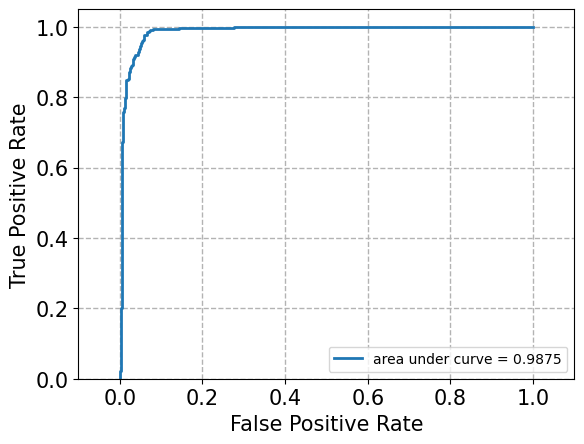

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

class WordEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word_vectors):
        self.word_vectors = word_vectors

    def fit(self, X, y=None):
        # No fitting necessary, just return self
        return self

    def transform(self, X):
        # Convert each document in X to its word embedding representation
        embedded_X = []
        for text in X:
            # Tokenize the text and filter out-of-vocabulary words
            tokens = text.split()
            vectors = [self.word_vectors[word] for word in tokens if word in self.word_vectors]

            # Calculate the average vector for the document
            if vectors:
                doc_embedding = np.mean(vectors, axis=0)
            else:
                doc_embedding = np.zeros(300)

            embedded_X.append(doc_embedding)

        return np.array(embedded_X)

class MultiTextEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word_vectors):
        self.word_vectors = word_vectors

    def fit(self, X, y=None):
        # No fitting necessary, just return self
        return self

    def transform(self, X):
        embedded_X = []
        for full_text, keywords in zip(X['full_text'], X['keywords']):
            # Process full_text
            full_text_tokens = full_text.split()
            full_text_vectors = [self.word_vectors[word] for word in full_text_tokens if word in self.word_vectors]
            full_text_embedding = np.mean(full_text_vectors, axis=0) if full_text_vectors else np.zeros(self.word_vectors.vector_size)

            # Process keywords
            keyword_vectors = [self.word_vectors[word] for word in keywords if word in self.word_vectors]
            keywords_embedding = np.mean(keyword_vectors, axis=0) if keyword_vectors else np.zeros(self.word_vectors.vector_size)

            # Concatenate embeddings
            combined_embedding = np.concatenate([full_text_embedding, keywords_embedding])

            embedded_X.append(combined_embedding)

        return np.array(embedded_X)



# Create a pipeline with WordEmbeddingVectorizer and SVM classifier
pipeline = Pipeline([
    ('word_embedding', MultiTextEmbeddingVectorizer(embeddings_dict_300)),
    ('classifier', SVC(kernel='linear'))
])

# Train the pipeline on the text data
pipeline.fit(train[['full_text', 'keywords']], y_train)

y_pred = pipeline.predict(test[['full_text', 'keywords']])

print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))


prob_score = pipeline.decision_function(test[['full_text', 'keywords']])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

### Q11-b
- <font size="4"> **Select a classifier model, train and evaluate it with your GLoVE-based feature.**

WordEmbeddingVectorizer and MultiTextEmbeddingVectorizer classes are modified here to preprocess the 'full_text' column by lemmatizing.

In [139]:
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

class WordEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word_vectors, lemmatizer=None):
        self.word_vectors = word_vectors
        self.vector_size = len(next(iter(word_vectors.values())))  # Get the vector size
        self.lemmatizer = lemmatizer or WordNetLemmatizer()

    def fit(self, X, y=None):
        # No fitting necessary, just return self
        return self
    
    def transform(self, X):
        embedded_X = []
        for doc in X:
            tokens = self.tokenize_and_lemmatize(doc)  # Tokenize and lemmatize the document
            vectors = [self.word_vectors[word] for word in tokens if word in self.word_vectors]

            if vectors:
                doc_embedding = np.mean(vectors, axis=0)  # Calculate mean embedding
            else:
                doc_embedding = np.zeros(self.vector_size)  # Use zero vector if no embeddings found

            embedded_X.append(doc_embedding)

        return np.array(embedded_X)

    def tokenize_and_lemmatize(self, text):
        tokens = nltk.word_tokenize(text.lower())  # Tokenize the text
        lemmatized_tokens = [self.lemmatize_token(token) for token in tokens]
        return lemmatized_tokens

    def lemmatize_token(self, token):
        tag = nltk.pos_tag([token])[0][1][0].upper()  # Get the POS tag
        tag_dict = {
            'J': wordnet.ADJ,
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV
        }
        pos_tag = tag_dict.get(tag, wordnet.NOUN)  # Default to noun if tag not found
        return self.lemmatizer.lemmatize(token, pos=pos_tag)

    
class MultiTextEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word_vectors, lemmatizer=None):
        self.word_vectors = word_vectors
        self.vector_size = len(next(iter(word_vectors.values())))  # Get the vector size
        self.lemmatizer = lemmatizer or WordNetLemmatizer()

    def fit(self, X, y=None):
        # No fitting necessary, just return self
        return self
    
    def transform(self, X):
        embedded_X = []
        for doc, keywords in zip(X['full_text'], X['keywords']):
            tokens = self.tokenize_and_lemmatize(doc)  # Tokenize and lemmatize the document
            vectors = [self.word_vectors[word] for word in tokens if word in self.word_vectors]

            if vectors:
                full_text_embedding = np.mean(vectors, axis=0)  # Calculate mean embedding
            else:
                full_text_embedding = np.zeros(self.vector_size)  # Use zero vector if no embeddings found

            
            # Process keywords
            keyword_vectors = [self.word_vectors[word] for word in keywords if word in self.word_vectors]
            keywords_embedding = np.mean(keyword_vectors, axis=0) if keyword_vectors else np.zeros(self.word_vectors.vector_size)

            # Concatenate embeddings
            combined_embedding = np.concatenate([full_text_embedding, keywords_embedding])

            embedded_X.append(combined_embedding)

        return np.array(embedded_X)

    def tokenize_and_lemmatize(self, text):
        tokens = nltk.word_tokenize(text.lower())  # Tokenize the text
        lemmatized_tokens = [self.lemmatize_token(token) for token in tokens]
        return lemmatized_tokens

    def lemmatize_token(self, token):
        tag = nltk.pos_tag([token])[0][1][0].upper()  # Get the POS tag
        tag_dict = {
            'J': wordnet.ADJ,
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV
        }
        pos_tag = tag_dict.get(tag, wordnet.NOUN)  # Default to noun if tag not found
        return self.lemmatizer.lemmatize(token, pos=pos_tag)


a) When using just the full_text column:

Fitting 3 folds for each of 60 candidates, totalling 180 fits
best params are: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
accuracy on test: 0.9741379310344828
precision on test: 0.9737033486496314
recall on test: 0.9748806998939554
F_score on test: 0.9740897922716104
Confusion matrix on test: 
 [[354  14]
 [  4 324]]


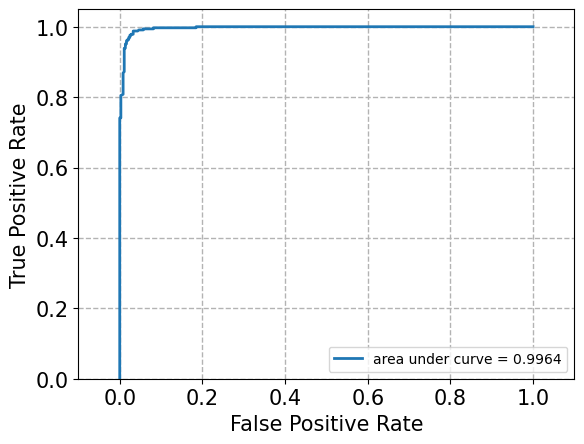

In [133]:
# grid search
KERNEL_OPTIONS2 = ['linear', 'rbf', 'sigmoid']
KERNEL_OPTIONS2 = [ 'rbf']

pipeline_svm_2 = Pipeline([
    ('word_embedding', WordEmbeddingVectorizer(embeddings_dict_300)),
    ('clf', SVC(gamma= 'auto'))
])

param_grid = [
    {
        'clf__kernel': KERNEL_OPTIONS2,
        'clf__C': [0.0001, 0.001, 0.01, 0.03, 0.1, .3, 1, 10, 100, 1000 ],
        'clf__gamma': [  0.001, 0.01, 0.1, 1, 10, 100]
        
        
    },
#     {
#         'clf__kernel': ['poly'],
#         'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000 ],
#         'clf__degree': [2,3,4],
#         'clf__gamma': [ 0.001, 0.01, 0.1, 1, 10, 100]
        
        
#     }
]

grid_SVM_3 = GridSearchCV(pipeline_svm_2, cv=3, n_jobs=1, param_grid=param_grid, scoring='roc_auc', verbose=1)

# Train the pipeline on the text data
grid_SVM_3.fit(train['full_text'], y_train)

y_pred = grid_SVM_3.best_estimator_.predict(test['full_text'])

print('best params are:',grid_SVM_3.best_params_)
print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))


prob_score = grid_SVM_3.decision_function(test['full_text'])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

b) When incorporating the keywords column in addition to full_text -->

Fitting 2 folds for each of 16 candidates, totalling 32 fits
best params are: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
accuracy on test: 0.9698275862068966
precision on test: 0.9693983788205548
recall on test: 0.9706389183457051
F_score on test: 0.9697751124437781
Confusion matrix on test: 
 [[352  16]
 [  5 323]]


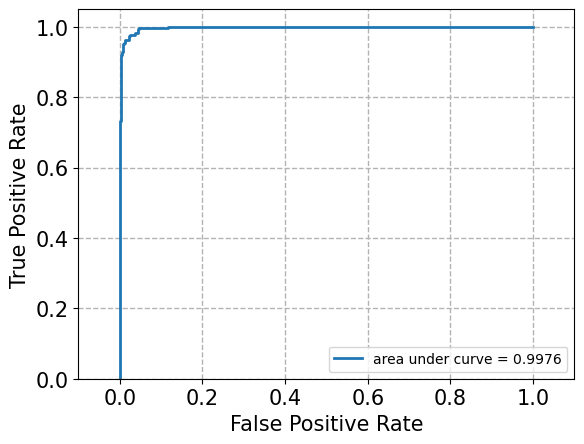

In [144]:
# grid search
KERNEL_OPTIONS2 = ['linear', 'rbf', 'sigmoid']
KERNEL_OPTIONS2 = [ 'rbf']

pipeline_svm_2 = Pipeline([
    ('word_embedding', MultiTextEmbeddingVectorizer(embeddings_dict_300)),
    ('clf', SVC(gamma= 'auto'))
])

param_grid = [
    {
        'clf__kernel': KERNEL_OPTIONS2,
        'clf__C': [   1, 10, 100, 1000],
        'clf__gamma': [0.01, .1, 1, 10 ]
        
        
    }
]

grid_SVM_3 = GridSearchCV(pipeline_svm_2, cv=2, n_jobs=1, param_grid=param_grid, scoring='roc_auc', verbose=1)

# Train the pipeline on the text data
grid_SVM_3.fit(train[['full_text', 'keywords']], y_train)

y_pred = grid_SVM_3.best_estimator_.predict(test[['full_text', 'keywords']])

print('best params are:',grid_SVM_3.best_params_)
print ('accuracy on test:', accuracy_score(y_test, y_pred))
print ('precision on test:', precision_score(y_test, y_pred, average='macro'))
print ('recall on test:', recall_score(y_test, y_pred, average='macro'))
print ('F_score on test:', f1_score(y_test, y_pred, average='macro'))
print ('Confusion matrix on test: \n', confusion_matrix(y_test, y_pred))


prob_score = grid_SVM_3.decision_function(test[['full_text', 'keywords']])
fpr, tpr, _ = roc_curve(y_test, prob_score)

plot_roc(fpr, tpr)

### Question 11-b (answer)

Observation:
When using GLoVE word embedding of dimension 300, I studied three cases: 

1- without lemmatizing + using both 'full_text' and 'keywords' columns

2- lemmatize + use only 'full_text'

3- lemmatize + using both 'full_text' and 'keywords' columns

For both case 2 and 3, hyperparmater tuning is applied using grid search. The summary of the performance of the best estimator on the test dataset is shown as follows:
|                 | accuracy        | precision       | recall          | F_score         | AOC ROC |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
case1             | 0.946839        | 0.946731        | 0.946580        | 0.946653        | 0.9875          |
case2             | 0.974137        | 0.973703        | 0.974880        | 0.974089        | 0.9964          |
case3             | 0.969827        | 0.969398        | 0.970638        | 0.969775        | 0.9976          |

As seen in the table above, the AOC for case3 is the highest. This AOC is same as the result for question 8 in which no word embedding was used. I suppose one can get better results with word embedding with better choices for hyperparameters. However, there is still a slight improvement if one compare the accuracy. The accuracy for case2 is 0.9741 which is improvement in comparison to 0.9728 which was the best from grid search in Question 8.

## QUESTION 12

- **Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.**


In [70]:
embd_list = [embeddings_dict_50, embeddings_dict_100, embeddings_dict_200, embeddings_dict_300]
embd_size = [50, 100, 200, 300]

In [71]:
accuracy_list_embed_dim = []
for i, embd_dict in enumerate(embd_list):
    pipeline = Pipeline([
    ('word_embedding', MultiTextEmbeddingVectorizer(embd_dict)),
    ('classifier', SVC(kernel='linear'))
    ])

    # Train the pipeline on the text data
    pipeline.fit(train[['full_text', 'keywords']], y_train)

    y_pred = pipeline.predict(test[['full_text', 'keywords']])
    accuracy_list_embed_dim.append(accuracy_score(y_test, y_pred))
    print ('case 1: dimension of embedding = {} accuracy on test is'.format(embd_size[i]), accuracy_score(y_test, y_pred))

case 1: dimension of embedding = 50 accuracy on test is 0.9281609195402298
case 1: dimension of embedding = 100 accuracy on test is 0.9339080459770115
case 1: dimension of embedding = 200 accuracy on test is 0.9425287356321839
case 1: dimension of embedding = 300 accuracy on test is 0.9468390804597702


([<matplotlib.axis.XTick at 0x7f7d36b6b9d0>,
 [Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(200, 0, '200'),
  Text(300, 0, '300')])

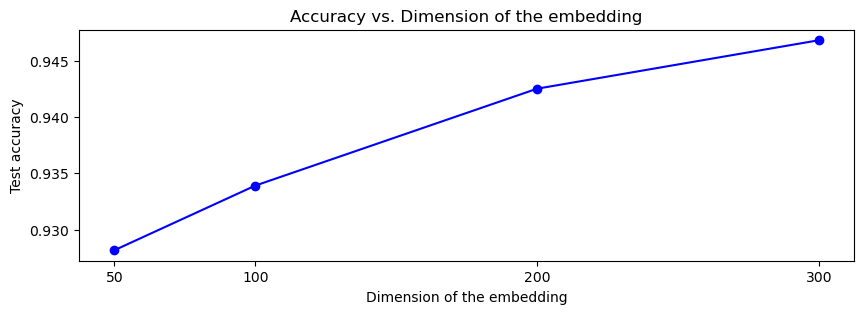

In [72]:
plt.figure(figsize=(10, 3))
plt.plot(embd_size, accuracy_list_embed_dim, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Dimension of the embedding')
plt.xlabel('Dimension of the embedding')
plt.ylabel('Test accuracy')
plt.xticks(embd_size)

## QUESTION 12 (answer)

- **Describe the observed trend. Is this trend expected? Why or why not?**

As shown in above graph, the test accuracy improves with higher dimension of the embedding. Yes, this trend was expected. Because as the dimension of the embedding grows, number of features representing the documnet also grows and therefore the model complexity is heightened. With more complex model, one can expect better performance conditioned on appropriate amount of training and fine tuning.

## Visualize GLoVE-based embedding using UMAP

## QUESTION 13 

In [73]:
import umap
import umap.plot


2024-04-18 09:11:52.719097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Axes: >

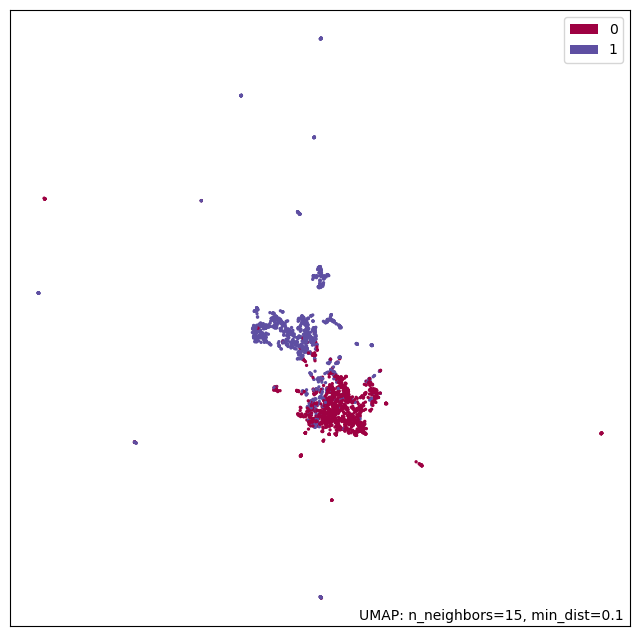

In [74]:
embedded_X = []
for text in train['full_text']:
    # Tokenize the text and filter out-of-vocabulary words
    tokens = text.split()
    vectors = [embeddings_dict_300[word] for word in tokens if word in embeddings_dict_300]

    # Calculate the average vector for the document
    if vectors:
        doc_embedding = np.mean(vectors, axis=0)
    else:
        doc_embedding = np.zeros(300)

    embedded_X.append(doc_embedding)
    
train_golve_embeded = np.array(embedded_X)

mapper = umap.UMAP(random_state=42).fit(train_golve_embeded)
umap.plot.points(mapper, labels=y_train)

<Axes: >

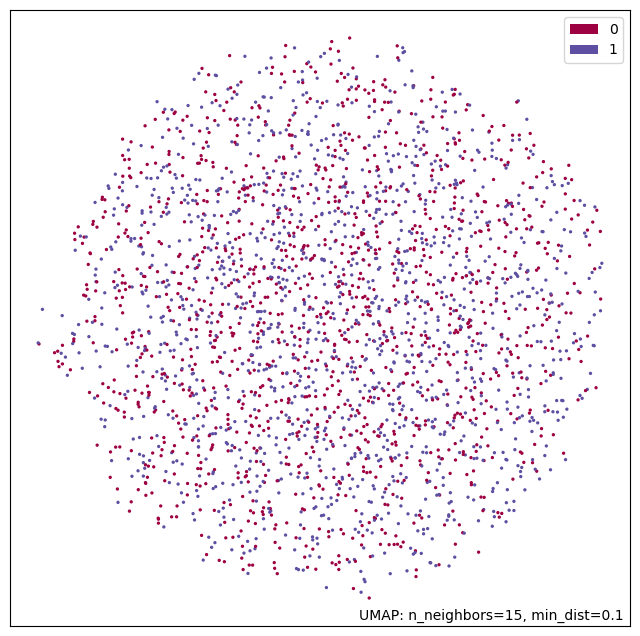

In [75]:
# Random vectors
X_random = np.random.rand(train.shape[0], 300)
mapper = umap.UMAP(random_state=42).fit(X_random)
umap.plot.points(mapper, labels=y_train)

## QUESTION 13 (answer)

- **Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots?**

As shown in above graph, when the normalize GLoVE-bsaed embeddings of the documents are visualized in a 2D plane, two clusters are formed for each of the classes (labels). On the other hand, the random vector of the same size as GLoVE dimension (300) are scatterd uniformly among the two classes, and there is no distinct cluster representing each class.